In [93]:
import zipfile

zip_file_path = '/content/deep-learning-spring-2025-project-1.zip'
destination_folder = 'Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    z.extractall(destination_folder)

print(f"Files extracted to: {destination_folder}")

Files extracted to: Dataset


In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/Dataset/cifar_test_nolabel.pkl
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_4
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_5
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_2
/content/Dataset/cifar-10-python/cifar-10-batches-py/test_batch
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_3
/content/Dataset/cifar-10-python/cifar-10-batches-py/readme.html
/content/Dataset/cifar-10-python/cifar-10-batches-py/batches.meta
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_1


In [95]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes_dict = unpickle("/content/Dataset/cifar-10-python/cifar-10-batches-py/batches.meta")
label_names = classes_dict[b'label_names']
print(label_names)

# Load training data in batches, then combine
training_data = []
training_labels = []
for i in range(1, 6):
    training_fp = "/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_{}".format(i)
    batch = unpickle(training_fp)
    batch_data = batch[b'data']
    batch_labels = batch[b'labels']
    for i in range(len(batch_data)):
        training_data.append(batch_data[i])
        training_labels.append(batch_labels[i])

print(len(training_data))
print(len(training_labels))

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
50000
50000


In [96]:
import numpy as np
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image

# Assuming training_labels is a NumPy array
training_labels = np.array(training_labels)

def transform_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL for augmentation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0, inplace=False),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization
    ])
    return transform(image)

def transform_validation(image):
    valid_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return valid_transform(image)

# Convert and reshape training data
training_data = np.array(training_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Split data into training and validation sets
training_count = int(0.8 * len(training_data))
validation_count = len(training_data) - training_count  # To make sure the total count adds up

# Apply random_split on training data and corresponding labels
train_data, val_data = random_split(list(zip(training_data, training_labels)), [training_count, validation_count])

# Apply transformations to training and validation data
training_data = [(transform_image(image), label) for image, label in train_data]
validation_data = [(transform_validation(image), label) for image, label in val_data]

# Check the shapes of transformed images
print(training_data[0][0].shape)  # Training data
print(validation_data[0][0].shape)  # Validation data


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

#Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #when in_channels != out_channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  #residual connection
        out = self.relu(out)
        out = self.dropout(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = ResidualBlock(64, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256,512, stride = 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

In [107]:
# Create an instance of the model
model = SimpleResNet()

# Define optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay

# Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 4907466


In [108]:
import torch.optim as optim
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
            Conv2d-6           [-1, 64, 16, 16]          36,864
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]           4,096
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
    ResidualBlock-12           [-1, 64, 16, 16]               0
           Conv2d-13            [-1, 128, 8, 8]          73,728
      BatchNorm2d-14            [-1, 12

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Training Loss: 2.3238, Training Accuracy: 13.50%, Validation Accuracy: 13.34%, LR: 0.000010
Epoch 2: Training Loss: 2.1515, Training Accuracy: 19.48%, Validation Accuracy: 16.59%, LR: 0.000010
Epoch 3: Training Loss: 2.0509, Training Accuracy: 22.61%, Validation Accuracy: 18.05%, LR: 0.000010
Epoch 4: Training Loss: 1.9715, Training Accuracy: 25.70%, Validation Accuracy: 18.90%, LR: 0.000010
Epoch 5: Training Loss: 1.9082, Training Accuracy: 28.31%, Validation Accuracy: 21.06%, LR: 0.000010
Epoch 6: Training Loss: 1.8617, Training Accuracy: 30.36%, Validation Accuracy: 21.90%, LR: 0.000009
Epoch 7: Training Loss: 1.8269, Training Accuracy: 31.71%, Validation Accuracy: 24.98%, LR: 0.000009
Epoch 8: Training Loss: 1.7875, Training Accuracy: 33.14%, Validation Accuracy: 28.35%, LR: 0.000009
Epoch 9: Training Loss: 1.7590, Training Accuracy: 34.43%, Validation Accuracy: 29.51%, LR: 0.000009
Epoch 10: Training Loss: 1.7344, Training Accuracy: 35.34%, Validation Accuracy: 30.18%, LR

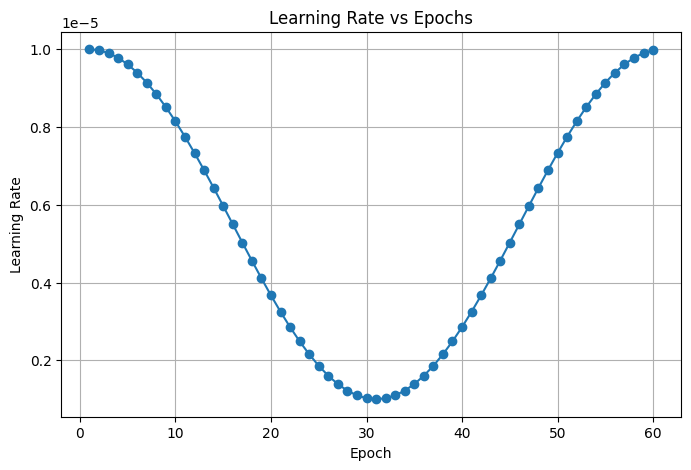

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 1.3663, Training Accuracy: 50.67%, Validation Accuracy: 46.86%, LR: 0.000010
Epoch 2: Training Loss: 1.3635, Training Accuracy: 50.73%, Validation Accuracy: 48.21%, LR: 0.000010
Epoch 3: Training Loss: 1.3497, Training Accuracy: 51.45%, Validation Accuracy: 45.58%, LR: 0.000010
Epoch 4: Training Loss: 1.3422, Training Accuracy: 51.40%, Validation Accuracy: 49.61%, LR: 0.000010
Epoch 5: Training Loss: 1.3357, Training Accuracy: 51.88%, Validation Accuracy: 49.57%, LR: 0.000010
Epoch 6: Training Loss: 1.3229, Training Accuracy: 52.25%, Validation Accuracy: 49.59%, LR: 0.000009
Epoch 7: Training Loss: 1.3130, Training Accuracy: 53.08%, Validation Accuracy: 49.77%, LR: 0.000009
Epoch 8: Training Loss: 1.3105, Training Accuracy: 52.78%, Validation Accuracy: 50.92%, LR: 0.000009
Epoch 9: Training Loss: 1.2962, Training Accuracy: 53.48%, Validation Accuracy: 51.82%, LR: 0.000009
Epoch 10: Training Loss: 1.2887, Training Accuracy: 53.52%, Validation Accuracy: 51.27%, LR

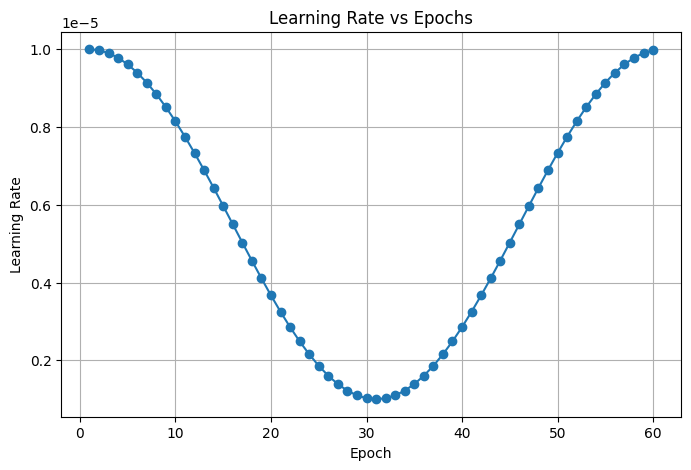

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 1.1527, Training Accuracy: 58.89%, Validation Accuracy: 60.75%, LR: 0.000050
Epoch 2: Training Loss: 1.1327, Training Accuracy: 59.92%, Validation Accuracy: 61.82%, LR: 0.000050
Epoch 3: Training Loss: 1.1112, Training Accuracy: 60.26%, Validation Accuracy: 63.22%, LR: 0.000049
Epoch 4: Training Loss: 1.0867, Training Accuracy: 61.37%, Validation Accuracy: 62.84%, LR: 0.000049
Epoch 5: Training Loss: 1.0656, Training Accuracy: 62.27%, Validation Accuracy: 64.72%, LR: 0.000048
Epoch 6: Training Loss: 1.0390, Training Accuracy: 63.03%, Validation Accuracy: 65.15%, LR: 0.000047
Epoch 7: Training Loss: 1.0191, Training Accuracy: 63.69%, Validation Accuracy: 66.43%, LR: 0.000045
Epoch 8: Training Loss: 0.9948, Training Accuracy: 64.76%, Validation Accuracy: 67.28%, LR: 0.000044
Epoch 9: Training Loss: 0.9730, Training Accuracy: 65.54%, Validation Accuracy: 67.08%, LR: 0.000042
Epoch 10: Training Loss: 0.9580, Training Accuracy: 66.20%, Validation Accuracy: 68.35%, LR

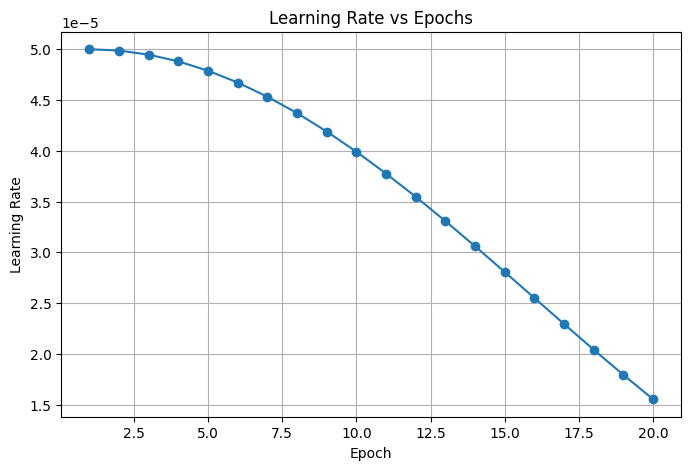

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 0.8447, Training Accuracy: 70.17%, Validation Accuracy: 71.47%, LR: 0.000050
Epoch 2: Training Loss: 0.8336, Training Accuracy: 70.70%, Validation Accuracy: 71.11%, LR: 0.000050
Epoch 3: Training Loss: 0.8247, Training Accuracy: 70.85%, Validation Accuracy: 72.16%, LR: 0.000049
Epoch 4: Training Loss: 0.8129, Training Accuracy: 71.35%, Validation Accuracy: 72.24%, LR: 0.000049
Epoch 5: Training Loss: 0.7878, Training Accuracy: 72.29%, Validation Accuracy: 73.30%, LR: 0.000048
Epoch 6: Training Loss: 0.7804, Training Accuracy: 72.45%, Validation Accuracy: 73.06%, LR: 0.000047
Epoch 7: Training Loss: 0.7663, Training Accuracy: 73.08%, Validation Accuracy: 73.17%, LR: 0.000045
Epoch 8: Training Loss: 0.7519, Training Accuracy: 73.50%, Validation Accuracy: 72.70%, LR: 0.000044
Epoch 9: Training Loss: 0.7387, Training Accuracy: 73.98%, Validation Accuracy: 74.14%, LR: 0.000042
Epoch 10: Training Loss: 0.7258, Training Accuracy: 74.49%, Validation Accuracy: 74.02%, LR

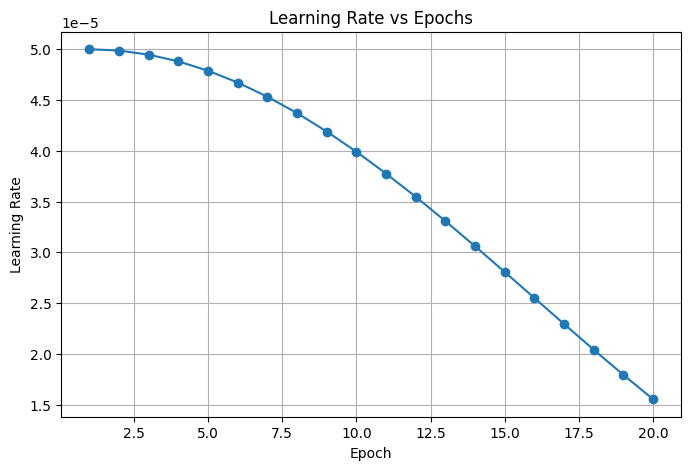

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 0.6421, Training Accuracy: 77.40%, Validation Accuracy: 75.27%, LR: 0.000050
Epoch 2: Training Loss: 0.6423, Training Accuracy: 77.24%, Validation Accuracy: 75.34%, LR: 0.000050
Epoch 3: Training Loss: 0.6327, Training Accuracy: 77.64%, Validation Accuracy: 75.86%, LR: 0.000049
Epoch 4: Training Loss: 0.6184, Training Accuracy: 78.14%, Validation Accuracy: 76.37%, LR: 0.000049
Epoch 5: Training Loss: 0.6105, Training Accuracy: 78.33%, Validation Accuracy: 76.08%, LR: 0.000048
Epoch 6: Training Loss: 0.6026, Training Accuracy: 78.74%, Validation Accuracy: 76.06%, LR: 0.000047
Epoch 7: Training Loss: 0.5903, Training Accuracy: 79.17%, Validation Accuracy: 76.89%, LR: 0.000045
Epoch 8: Training Loss: 0.5804, Training Accuracy: 79.65%, Validation Accuracy: 75.62%, LR: 0.000044
Epoch 9: Training Loss: 0.5697, Training Accuracy: 79.89%, Validation Accuracy: 76.49%, LR: 0.000042
Epoch 10: Training Loss: 0.5512, Training Accuracy: 80.40%, Validation Accuracy: 77.09%, LR

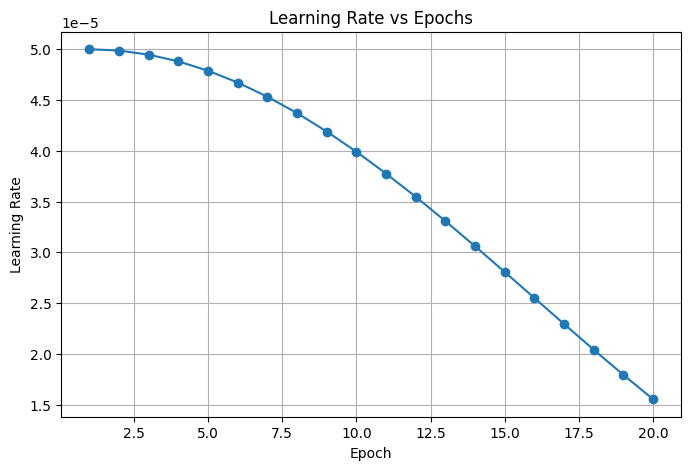

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 0.4354, Training Accuracy: 84.59%, Validation Accuracy: 78.49%, LR: 0.000010
Epoch 2: Training Loss: 0.4287, Training Accuracy: 84.69%, Validation Accuracy: 78.25%, LR: 0.000010
Epoch 3: Training Loss: 0.4139, Training Accuracy: 85.47%, Validation Accuracy: 78.51%, LR: 0.000010
Epoch 4: Training Loss: 0.4214, Training Accuracy: 85.14%, Validation Accuracy: 78.62%, LR: 0.000010
Epoch 5: Training Loss: 0.4119, Training Accuracy: 85.40%, Validation Accuracy: 78.57%, LR: 0.000010
Epoch 6: Training Loss: 0.4188, Training Accuracy: 85.19%, Validation Accuracy: 78.46%, LR: 0.000009
Epoch 7: Training Loss: 0.4092, Training Accuracy: 85.59%, Validation Accuracy: 78.13%, LR: 0.000009
Epoch 8: Training Loss: 0.4068, Training Accuracy: 85.66%, Validation Accuracy: 78.39%, LR: 0.000009
Epoch 9: Training Loss: 0.4114, Training Accuracy: 85.73%, Validation Accuracy: 78.66%, LR: 0.000009
Epoch 10: Training Loss: 0.4024, Training Accuracy: 85.70%, Validation Accuracy: 78.46%, LR

KeyboardInterrupt: 

Epoch 1: Training Loss: 0.5275, Training Accuracy: 81.28%, Validation Accuracy: 76.95%, LR: 0.000100
Epoch 2: Training Loss: 0.5443, Training Accuracy: 80.55%, Validation Accuracy: 77.37%, LR: 0.000100
Epoch 3: Training Loss: 0.5441, Training Accuracy: 80.59%, Validation Accuracy: 76.43%, LR: 0.000099
Epoch 4: Training Loss: 0.5318, Training Accuracy: 81.06%, Validation Accuracy: 76.68%, LR: 0.000098
Epoch 5: Training Loss: 0.5273, Training Accuracy: 81.08%, Validation Accuracy: 76.57%, LR: 0.000096
Training complete!


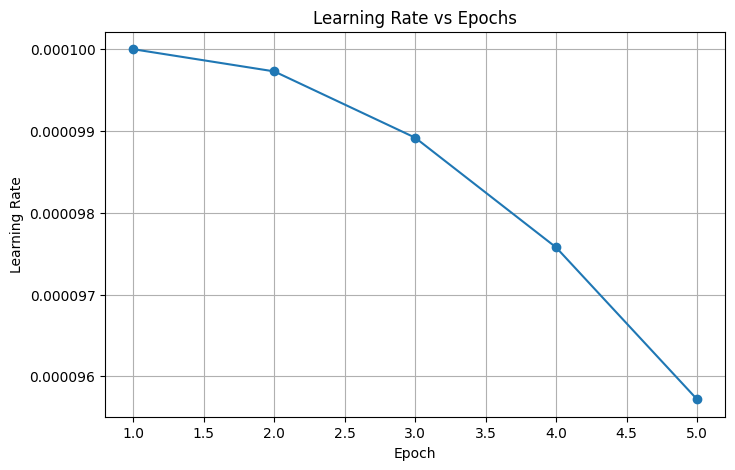

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 0.5255, Training Accuracy: 81.39%, Validation Accuracy: 78.54%, LR: 0.000100
Epoch 2: Training Loss: 0.5150, Training Accuracy: 81.72%, Validation Accuracy: 78.12%, LR: 0.000100
Epoch 3: Training Loss: 0.5042, Training Accuracy: 82.14%, Validation Accuracy: 78.27%, LR: 0.000099
Epoch 4: Training Loss: 0.4889, Training Accuracy: 82.72%, Validation Accuracy: 77.10%, LR: 0.000098
Epoch 5: Training Loss: 0.4749, Training Accuracy: 82.96%, Validation Accuracy: 78.24%, LR: 0.000096
Epoch 6: Training Loss: 0.4615, Training Accuracy: 83.55%, Validation Accuracy: 77.03%, LR: 0.000093
Epoch 7: Training Loss: 0.4446, Training Accuracy: 84.19%, Validation Accuracy: 77.57%, LR: 0.000091
Epoch 8: Training Loss: 0.4317, Training Accuracy: 84.60%, Validation Accuracy: 79.06%, LR: 0.000087
Epoch 9: Training Loss: 0.4163, Training Accuracy: 85.12%, Validation Accuracy: 79.37%, LR: 0.000084
Epoch 10: Training Loss: 0.3983, Training Accuracy: 85.86%, Validation Accuracy: 78.69%, LR

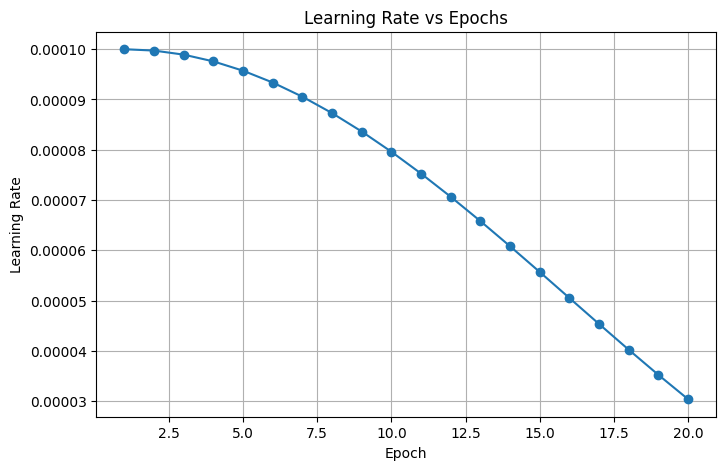

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)  # L2 Regularization
# Define LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
#cosine annealing try

# DataLoaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lr_history) + 1), lr_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.grid(True)
plt.show()


Epoch 1: Training Loss: 0.2434, Training Accuracy: 91.51%, Validation Accuracy: 80.24%, LR: 0.000010
Epoch 2: Training Loss: 0.2292, Training Accuracy: 91.94%, Validation Accuracy: 80.28%, LR: 0.000010
Epoch 3: Training Loss: 0.2249, Training Accuracy: 91.96%, Validation Accuracy: 80.67%, LR: 0.000010
Epoch 4: Training Loss: 0.2240, Training Accuracy: 92.19%, Validation Accuracy: 80.41%, LR: 0.000010
Epoch 5: Training Loss: 0.2221, Training Accuracy: 92.18%, Validation Accuracy: 80.50%, LR: 0.000010
Epoch 6: Training Loss: 0.2151, Training Accuracy: 92.50%, Validation Accuracy: 80.14%, LR: 0.000009
Epoch 7: Training Loss: 0.2130, Training Accuracy: 92.56%, Validation Accuracy: 80.32%, LR: 0.000009
Epoch 8: Training Loss: 0.2118, Training Accuracy: 92.46%, Validation Accuracy: 80.33%, LR: 0.000009
Epoch 9: Training Loss: 0.2054, Training Accuracy: 92.83%, Validation Accuracy: 80.44%, LR: 0.000009
Epoch 10: Training Loss: 0.2076, Training Accuracy: 92.71%, Validation Accuracy: 80.73%, LR

In [2]:
# Save the model
import torch
torch.save(model.state_dict(), 'epochs.pth')

NameError: name 'model' is not defined

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define DataLoader
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

# Load ResNet-18 model
model = models.resnet18(pretrained=True)
model = model.to(device)

# Modify the final fully connected layer to match the number of classes (e.g., 10 classes for CIFAR-10)
model.fc = nn.Linear(model.fc.in_features, 10)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move tensors to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'resnet18.pth')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define your model (ensure it matches the saved model architecture)
model = SmallBalancedResNet()  # Replace with your actual model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Try loading the saved model checkpoint
model_path = "small_balanced_resnet.pth"
try:
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded model weights from {model_path}")
except FileNotFoundError:
    print(f"No saved model found at {model_path}, starting training from scratch.")

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoaders for Training and Validation
training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predictions = torch.max(outputs, dim=1)

        num_predictions = labels.size(dim=0)
        num_correct = (predictions == labels).sum().item()

        total_train_predictions += num_predictions
        total_train_correct += num_correct

    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)

            num_predictions = labels.size(dim=0)
            num_correct = (predictions == labels).sum().item()

            total_val_predictions += num_predictions
            total_val_correct += num_correct

    train_acc = total_train_correct * 100 / total_train_predictions
    val_acc = total_val_correct * 100 / total_val_predictions
    avg_loss = running_loss / len(training_loader)

    print(f'Epoch {epoch+1} - Training Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    # Save model after every epoch
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

print("Training complete!")


Loaded model weights from small_balanced_resnet.pth
Epoch 1 - Training Loss: 0.2670, Training Accuracy: 90.85%, Validation Accuracy: 79.64%
Model saved at small_balanced_resnet.pth
Epoch 2 - Training Loss: 0.2461, Training Accuracy: 91.60%, Validation Accuracy: 79.06%
Model saved at small_balanced_resnet.pth
Epoch 3 - Training Loss: 0.2351, Training Accuracy: 92.00%, Validation Accuracy: 79.49%
Model saved at small_balanced_resnet.pth
Epoch 4 - Training Loss: 0.2234, Training Accuracy: 92.54%, Validation Accuracy: 80.46%
Model saved at small_balanced_resnet.pth
Epoch 5 - Training Loss: 0.2198, Training Accuracy: 92.56%, Validation Accuracy: 80.00%
Model saved at small_balanced_resnet.pth
Epoch 6 - Training Loss: 0.1963, Training Accuracy: 93.31%, Validation Accuracy: 79.20%
Model saved at small_balanced_resnet.pth
Epoch 7 - Training Loss: 0.1956, Training Accuracy: 93.47%, Validation Accuracy: 79.81%
Model saved at small_balanced_resnet.pth
Epoch 8 - Training Loss: 0.1877, Training Acc

In [ ]:
torch.save(model.state_dict(), "small_balanced_resnet.pth")

In [ ]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

# Define custom dataset class
class CIFARDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        with open(pkl_file, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')

        self.data = data_dict[b'data']  # 10000x3072 numpy array
        self.labels = data_dict[b'labels']  # List of 10000 labels

        # Reshape data to (10000, 3, 32, 32)
        self.data = self.data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(torch.tensor(img))

        return img, torch.tensor(label, dtype=torch.long)

# Define test dataset transformation (normalize to match model training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust based on training
])

# Create dataset and DataLoader
test_dataset = CIFARDataset('E:\\MS\\DL\\Try2\\deep-learning-spring-2025-project-1\\cifar-10-python\\cifar-10-batches-py\\test_batch', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to evaluate model accuracy
def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy




In [ ]:
# Example usage:
model = SmallBalancedResNet() # Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 10.0%


In [ ]:
# Load test dataset
testing_fp = 'deep-learning-spring-2025-project-1\\cifar_test_nolabel.pkl'
testing_batch = unpickle(testing_fp)
testing_data = testing_batch[b'data']

print(testing_data[0].shape)

(32, 32, 3)


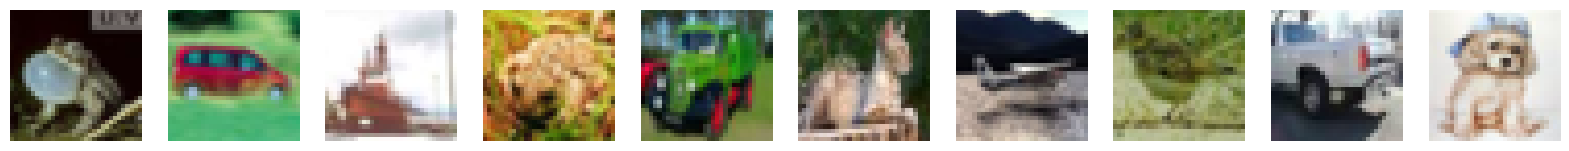

In [ ]:
# Displaying the first 10 images, since we can't see the labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(testing_data[i])
    plt.axis('off')
plt.show()

# [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck]
# So we should expect [6, 1, 8, 6, 9, 7, 8, 2, 9, 5] as the first 10 entries of our final CSV.

In [ ]:
# Changing to Tensor and adjusting shape before test
testing_data = [(transform_image(image),) for image in testing_data]
print(testing_data[0][0].shape)

# DataLoader
testing_loader = DataLoader(testing_data, batch_size=128, shuffle=False)

torch.Size([3, 32, 32])


In [ ]:
## Final output is file called submission.csv with columns ID, Labels

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in testing_loader:
        images = batch[0].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, dim=1)
        test_predictions.extend(predictions.cpu().numpy())

test_predictions_dict = {'ID': np.arange(len(test_predictions)), 'Labels': test_predictions}
test_predictions_df = pd.DataFrame(test_predictions_dict)
test_predictions_df.to_csv('submission1.csv', index=False)
print("Submitted! Check output for submission.csv")

Submitted! Check output for submission.csv
